# Neural Network from Scratch with Pytorch
PyTorch is an open-source machine learning framework and is widely used in research and in production. Eventhough you are free to use tensorflow we highly recommend using PyTorch!

[![Open In Colab]
    (https://colab.research.google.com/assets/colab-badge.svg)]
    [(https://colab.research.google.com/github/johannesmelsbach/ai-and-im/blob/main/notebooks/01%20-%20Neural%20Network.ipynb)]


In this notebook you will learn how to create a Neural Network with Pytorch that is able classify hand-written digits and does this with an accuracy of over 97%.

In [ ]:
import torch
import torch.nn as nn
import numpy as np

There are four required building blocks when it comes to training a neural network:
* Data
* Model
* Loss Function 
* Optimizer

In [ ]:
## Data
First of all we need data to train our network on. In the real world collecting and processing data is a very time consuming process. Luckily for us the research community published a lot of high quality datasets in the past that are ready to use for us.

In this notebook we will use the famous MNIST Dataset which consists of several thousand instances of handwritten digits with their coresponding labels.

 We download the dataset via the sklearn library. So we need to import sklearn and download the files

In [ ]:
from sklearn.datasets import fetch_openml

In [ ]:
%%time
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

CPU times: user 19.9 s, sys: 441 ms, total: 20.4 s
Wall time: 20.5 s


 We downloaded the dataset and saved created the variables `X` containing the pictures and `y` containing the labels. Let's have a closer look at the data.

In [ ]:
y.shape

(70000,)

`.shape` is a very useful command to see the dimensions of a vector or matrix. As we can see the shape of y is `(70000,)` which basically means it is a vector with 70000 rows. This means that we have 70000 labels and therefore 70000 examples in our dataset. Let's have a look at the first label:

In [ ]:
y[0]

'5'

Next we look at the pictures of the digits which are stored in the `X` variable.

In [ ]:
X.shape

(70000, 784)

The first dimension looks familiar. We had 70000 labels so it definitly makes sense to have 70000 images as well. You might have expected a three dimensional variable here, because images are a matrix of pixels. In this dataset the pictures are flattend into vectors with 784 dimensions. The original size of the images are 28x28 Pixels. 

If we want to look at the first picture of the dataset we have to reshape the images into a 28 by 28 matrix. We use `mathplotlib.pyplot.imshow()` to visualize the image.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
x0 = X[0]
x0 = x0.reshape([28,28])
x0.shape

(28, 28)

As you can see above currently the values range from 0 to 255. In Deep Learning we almost always want to have our input values to range from 0 to 1 instead. Scaling the data is very easy:

In [ ]:
X = X / 255.0

Label:  5


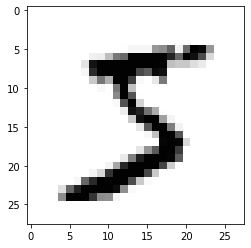

In [ ]:
plt.imshow(x0.reshape(28,28), cmap='Greys')
# print the corresponding label
print("Label: ", y[0])

### Datasets and Dataloaders

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
y = y.astype('int8')

In [ ]:
class MNISTDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X).float() / 255.
    self.y = torch.tensor(y).long()

  def __len__(self):
    return len(self.y)
  
  def __getitem__(self, index):
    return (self.X[index], self.y[index])

In [ ]:
mnist_data = MNISTDataset(X, y)

In [ ]:
mnist_dl = DataLoader(mnist_data, batch_size=8) 

In [ ]:
list(mnist_dl)[0]


[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9, 2, 1, 3])]

In [ ]:
# input
mnist_data[0][0]
# label
mnist_data[0][1]

tensor(5)

## The Neural Network

In [ ]:
import torch.nn.functional as F

In [ ]:
class NeuralNetworkV1(nn.Module):
  def __init__(self):
    super(NeuralNetworkV1, self).__init__()
    self.l1 = nn.Linear(784,100)
    self.l2 = nn.Linear(100, 10)
  
  def forward(self, X):
    X = F.sigmoid(self.l1(X))
    X = self.l2(X)
    return X

In [ ]:
net1 = NeuralNetworkV1()

In [ ]:
%%time
output = net1(mnist_data[0][0])
print(output)
print(output.shape)

tensor([-0.1255, -0.5945, -0.0460,  0.1227,  0.0603,  0.2812, -0.5580, -0.0538,
         0.1167, -0.0696], grad_fn=<AddBackward0>)
torch.Size([10])
CPU times: user 5.08 ms, sys: 2.09 ms, total: 7.18 ms
Wall time: 56.9 ms


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


This was one forward pass through our neural network. We get an output of shape `[10]` but of random positive and negative numbers.

Instead of random numbers we want our network to output probabilties, where hopefully the correct number has the highest probability. We have to modify our output in a way that it outputs probabilities, which implies to properties:
* Each output *must* be between `0` and `1`
* All outputs have to add up to `1` in total


> 💭 Think a moment why these to properties must be true 

In [ ]:
def softmax(x):
  return x.exp() / x.exp().sum()

In [ ]:
class NeuralNetworkV2(nn.Module):
  def __init__(self):
    super(NeuralNetworkV2, self).__init__()
    self.l1 = nn.Linear(784,100)
    self.l2 = nn.Linear(100, 10)
  
  def forward(self, X):
    X = F.sigmoid(self.l1(X))
    X = self.l2(X)
    X1 = softmax(X)
    X = F.softmax(X, dim=0)
    return X, X1

$$
\text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}
$$

In [ ]:
net2 = NeuralNetworkV2()

In [ ]:
%%time
output = net2(torch.tensor(X[0]).float() / 256)
print(output[0], output[1])

tensor([0.0865, 0.1059, 0.0775, 0.1482, 0.0686, 0.0872, 0.0925, 0.0629, 0.1212,
        0.1495], grad_fn=<SoftmaxBackward>) tensor([0.0865, 0.1059, 0.0775, 0.1482, 0.0686, 0.0872, 0.0925, 0.0629, 0.1212,
        0.1495], grad_fn=<DivBackward0>)
CPU times: user 5.05 ms, sys: 1.01 ms, total: 6.06 ms
Wall time: 45.2 ms


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
# Throws an AssertError if the condition is not true
assert 1.0 == output[0].sum()

As you can see we reached our goal. Every output is a number between zero and one and all outputs add up to 1. However, all outputs probabilities are about the same at about `0.1`. Which basically means that our network has no idea which digit is shown here. And how should it? It hasn't learned anything yet.

## Loss Function

We need a way to see how good or how bad our neural net is doing.